In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import create_train_test

In [4]:
X_raw_train, X_raw_test, y_train_list, y_test_list = create_train_test()

In [5]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [15]:
def create_lemma(X_list):
    X_lemma_list = []
    
    for x_file in X_list:
        x_file_lemma = []
        for sentence in x_file:
            words = nltk.word_tokenize(sentence)   
            x_file_lemma.append(" ".join( [wordnet_lemmatizer.lemmatize(word) for word in words] ) )
        X_lemma_list.append(x_file_lemma)
    return X_lemma_list
        
X_lemma_train = create_lemma(X_raw_train)
X_lemma_test = create_lemma(X_raw_test)

In [32]:
from nltk.corpus import stopwords 

def remove_stop_words(X_list):
    stop_words = set(stopwords.words('english')) 
  
    X_wsw_list = []
    for x_file in X_list:
        x_file_wsw = []
        for sentence in x_file:
            words = nltk.word_tokenize(sentence)
            words = [w for w in words if not w in stop_words]
            if len([w for w in words if not w in stop_words]) > 0:
                x_file_wsw.append(" ".join(words))
        X_wsw_list.append(x_file_wsw)
    return X_wsw_list

X_train_trans_list = remove_stop_words(X_lemma_train)
X_test_trans_list = remove_stop_words(X_lemma_test)

In [33]:
from termcolor import colored
file_number = 7

for sent, label in zip(X_train_trans_list[file_number], y_train_list[file_number]):
    if label == 1:
        print(colored(sent, 'red'))
    else:
        print(sent)

hey vinyl head
get recent standup special real double lp
go pod swag dot com slash w f click merch link wts podcast
get signed copy youre grab shirt poster wto related stuff
right
okay let show
right let
fucker fuck buddy fuck easter
whats happening
hows everybody
ok
little tricky
next couple show
well show thursday prerecorded last week business partner genius producer mr brandon macdonald taking welldeserved vacation
get
reason im bringing buster keaton arc
emergency illness arc
thing better buster ill tell
want say
one thousandth episode coming yet
thats lot
like almost decade well
ok know like read email air want hear question might
approach milestone 1000 episode know email know question thousand episode show past guest want follow ask question personally question go mike behind scene advice think might able dispense
im willing give shot want talk relationship show
would like hear different way way want
im inviting go ahead send send thing wts pot gmail dot com
could get u questio

In [35]:
from utils import create_ft_sent_vectors
create_ft_sent_vectors(X_train_trans_list, X_test_trans_list, y_train_list, y_test_list, "sent_lemma_without_sw.pkl",
                          epoch=200, minn=1, maxn=6, dim=100, model='skipgram')

Number of sentences: 18349
Train unsupervised model.
Model trained with user parameters:
{'verbose': 1, 'epoch': 200, 'minn': 1, 'maxn': 6, 'dim': 100, 'model': 'skipgram'}.


In [1]:
import pickle
with open("sent_lemma_without_sw.pkl", 'rb') as f:
    X_train_list, X_test_list, y_train_list, y_test_list = pickle.load(f)

In [2]:
from utils import create_rec_data

X_train_rec, y_train_rec, mask_train_rec = create_rec_data(X_train_list, y_train_list, 50)
X_test_rec, y_test_rec, mask_test_rec = create_rec_data(X_test_list, y_test_list, 50)
y_train_rec = y_train_rec[:, :, None]
y_test_rec = y_test_rec[:, :, None]

print(X_train_rec.shape, y_train_rec.shape, mask_train_rec.shape)
print(X_test_rec.shape, y_test_rec.shape, mask_test_rec.shape)

(380, 50, 100) (380, 50, 1) (380, 50)
(158, 50, 100) (158, 50, 1) (158, 50)


In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Bidirectional, TimeDistributed, GRU, Dense
from tensorflow.keras.metrics import Precision, Recall

max_sent = 50
features = 100

metrics=[Precision(), Recall()]

In [37]:
seed = 1
tf.random.set_seed(seed)

input = Input(shape=(max_sent, features))
model = Dropout(0.4)(input)
model = Bidirectional(GRU(units=200, return_sequences=True, recurrent_dropout=0.1))(model) 
model = Dropout(0.4)(model)
model = TimeDistributed(Dense(100, activation="sigmoid"))(model) 
model = Dropout(0.4)(model)
out = TimeDistributed(Dense(1, activation="sigmoid"))(model)  

model = Model(input, out)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)

In [38]:
from os.path import exists, join
from os import mkdir

weight_dir = 'weights_lemma_wsw'
checkpoint_filepath = join(weight_dir, 'saved-weight-{epoch:02d}.hdf5')

if not exists(weight_dir):
    mkdir(weight_dir)


saver_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=False,
    save_freq=1)

history = model.fit(X_train_rec, y_train_rec, batch_size=50, epochs=200, callbacks=[saver_callback], validation_data=(X_test_rec, y_test_rec))

Epoch 1/200
8/8 [==============================] - 5s 658ms/step - loss: 0.6232 - precision: 0.0550 - recall: 0.2862 - val_loss: 0.2485 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
8/8 [==============================] - 3s 408ms/step - loss: 0.2481 - precision: 0.0250 - recall: 0.0011 - val_loss: 0.2136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
8/8 [==============================] - 3s 433ms/step - loss: 0.2321 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1760 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
8/8 [==============================] - 3s 419ms/step - loss: 0.2095 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1775 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
8/8 [==============================] - 3s 427ms/step - loss: 0.2070 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/200
8/8 [==============

Epoch 45/200
8/8 [==============================] - 3s 401ms/step - loss: 0.0930 - precision: 0.7199 - recall: 0.6267 - val_loss: 0.1230 - val_precision: 0.6471 - val_recall: 0.1000
Epoch 46/200
8/8 [==============================] - 3s 400ms/step - loss: 0.0955 - precision: 0.8061 - recall: 0.4535 - val_loss: 0.1192 - val_precision: 0.4549 - val_recall: 0.3212
Epoch 47/200
8/8 [==============================] - 3s 400ms/step - loss: 0.0857 - precision: 0.7717 - recall: 0.6075 - val_loss: 0.1230 - val_precision: 0.5583 - val_recall: 0.2758
Epoch 48/200
8/8 [==============================] - 3s 406ms/step - loss: 0.0913 - precision: 0.7751 - recall: 0.5861 - val_loss: 0.1181 - val_precision: 0.5109 - val_recall: 0.2848
Epoch 49/200
8/8 [==============================] - 3s 403ms/step - loss: 0.0836 - precision: 0.7957 - recall: 0.6374 - val_loss: 0.1229 - val_precision: 0.4478 - val_recall: 0.1818
Epoch 50/200
8/8 [==============================] - 3s 401ms/step - loss: 0.0866 - precisi

8/8 [==============================] - 3s 407ms/step - loss: 0.0696 - precision: 0.8240 - recall: 0.7059 - val_loss: 0.1337 - val_precision: 0.5481 - val_recall: 0.2242
Epoch 91/200
8/8 [==============================] - 3s 407ms/step - loss: 0.0694 - precision: 0.8372 - recall: 0.6545 - val_loss: 0.1240 - val_precision: 0.5284 - val_recall: 0.2818
Epoch 92/200
8/8 [==============================] - 3s 403ms/step - loss: 0.0634 - precision: 0.8441 - recall: 0.7123 - val_loss: 0.1352 - val_precision: 0.5962 - val_recall: 0.2818
Epoch 93/200
8/8 [==============================] - 3s 403ms/step - loss: 0.0684 - precision: 0.8215 - recall: 0.6449 - val_loss: 0.1219 - val_precision: 0.5138 - val_recall: 0.3394
Epoch 94/200
8/8 [==============================] - 3s 404ms/step - loss: 0.0646 - precision: 0.8529 - recall: 0.7134 - val_loss: 0.1490 - val_precision: 0.3780 - val_recall: 0.0939
Epoch 95/200
8/8 [==============================] - 3s 406ms/step - loss: 0.0704 - precision: 0.8111 - 

Epoch 135/200
8/8 [==============================] - 3s 402ms/step - loss: 0.0486 - precision: 0.9208 - recall: 0.7711 - val_loss: 0.1511 - val_precision: 0.4750 - val_recall: 0.2879
Epoch 136/200
8/8 [==============================] - 3s 399ms/step - loss: 0.0492 - precision: 0.8611 - recall: 0.7957 - val_loss: 0.1566 - val_precision: 0.5078 - val_recall: 0.2970
Epoch 137/200
8/8 [==============================] - 3s 399ms/step - loss: 0.0473 - precision: 0.9168 - recall: 0.7775 - val_loss: 0.1516 - val_precision: 0.5205 - val_recall: 0.2303
Epoch 138/200
8/8 [==============================] - 3s 401ms/step - loss: 0.0475 - precision: 0.9101 - recall: 0.7797 - val_loss: 0.1487 - val_precision: 0.5636 - val_recall: 0.2818
Epoch 139/200
8/8 [==============================] - 3s 405ms/step - loss: 0.0469 - precision: 0.8799 - recall: 0.7989 - val_loss: 0.1511 - val_precision: 0.5149 - val_recall: 0.3152
Epoch 140/200
8/8 [==============================] - 3s 405ms/step - loss: 0.0412 - p

Epoch 180/200
8/8 [==============================] - 3s 414ms/step - loss: 0.0347 - precision: 0.9033 - recall: 0.8492 - val_loss: 0.1595 - val_precision: 0.5706 - val_recall: 0.2818
Epoch 181/200
8/8 [==============================] - 3s 400ms/step - loss: 0.0342 - precision: 0.9100 - recall: 0.8545 - val_loss: 0.1535 - val_precision: 0.5968 - val_recall: 0.3364
Epoch 182/200
8/8 [==============================] - 3s 399ms/step - loss: 0.0422 - precision: 0.8977 - recall: 0.7979 - val_loss: 0.1459 - val_precision: 0.5906 - val_recall: 0.3061
Epoch 183/200
8/8 [==============================] - 3s 400ms/step - loss: 0.0422 - precision: 0.8654 - recall: 0.8321 - val_loss: 0.1760 - val_precision: 0.5738 - val_recall: 0.2121
Epoch 184/200
8/8 [==============================] - 3s 400ms/step - loss: 0.0359 - precision: 0.9446 - recall: 0.8203 - val_loss: 0.1447 - val_precision: 0.5766 - val_recall: 0.3879
Epoch 185/200
8/8 [==============================] - 3s 401ms/step - loss: 0.0428 - p

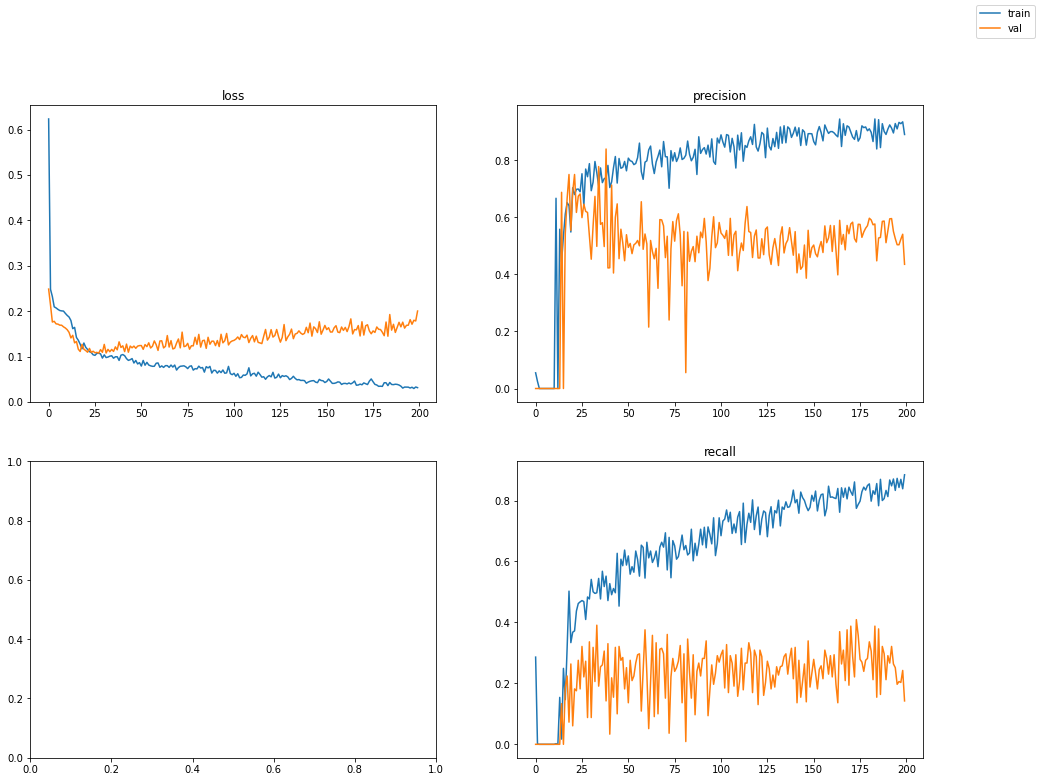

In [39]:
from utils import plot_loss_precision_recall
plot_loss_precision_recall(history.history['loss'], history.history['val_loss'], 
                           history.history['precision'], history.history['val_precision'], 
                           history.history['recall'], history.history['val_recall'])

In [32]:
best_epoch = 23
model.load_weights(checkpoint_filepath.format(epoch=best_epoch))
y_pred_probs = model.predict(X_test_rec)

In [33]:
from utils import make_flat

y_pred_probs_flat = make_flat(y_pred_probs, mask_test_rec) 
y_flat_true = make_flat(y_test_rec, mask_test_rec)

c:\users\roman\appdata\local\conda\conda\envs\tfft\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


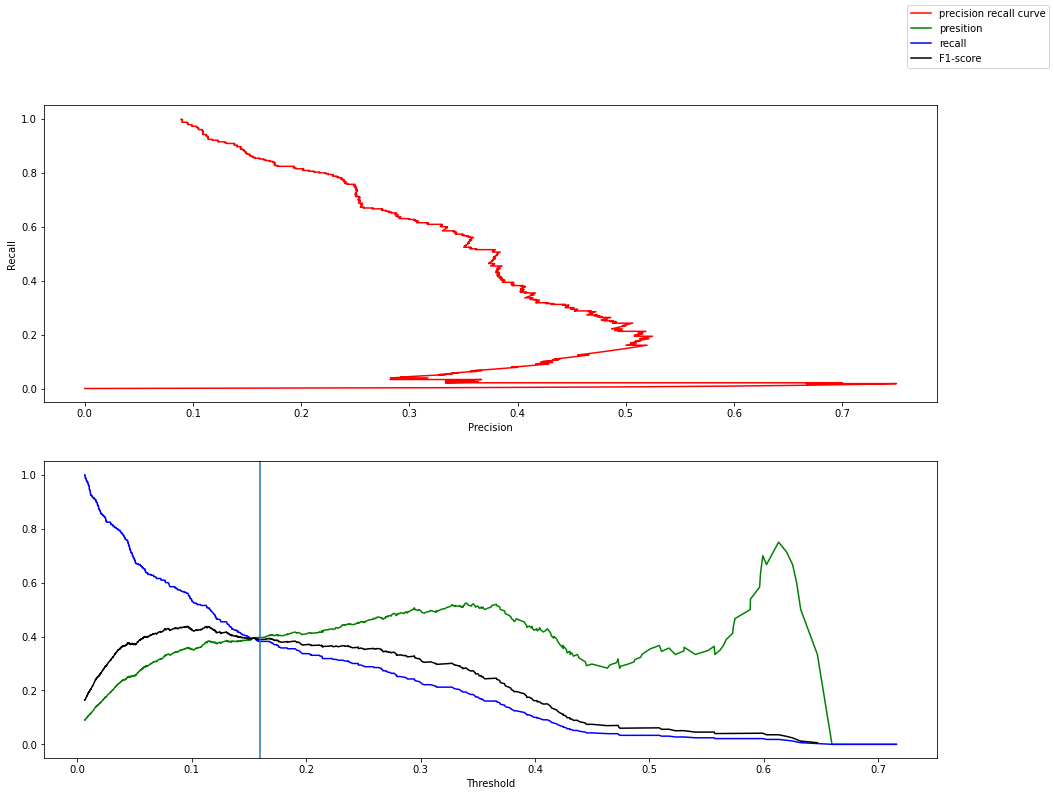

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_flat_true, y_pred_probs_flat)

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

ax[0].plot(precisions[:-1], recalls[:-1], color='red', label='precision recall curve')
ax[0].set_xlabel("Precision")
ax[0].set_ylabel("Recall")

ax[1].plot(thresholds, precisions[:-1], color='green', label='presition')
ax[1].plot(thresholds, recalls[:-1],  color='blue',label='recall')
ax[1].plot(thresholds, 2*recalls[:-1]*precisions[:-1]/(recalls[:-1]+precisions[:-1]),  color='black',label='F1-score')
ax[1].axvline(x=0.16)
ax[1].set_xlabel("Threshold")

fig.legend()
plt.show()

In [35]:
import numpy as np
y_flat_pred = np.zeros_like(y_pred_probs_flat)
y_flat_pred[y_pred_probs_flat >= 0.16] = 1

In [36]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
print(f1_score(y_flat_true, y_flat_pred))
print(classification_report(y_flat_true, y_flat_pred))
print(confusion_matrix(y_flat_true, y_flat_pred))

0.3888888888888889
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      7294
         1.0       0.40      0.38      0.39       330

    accuracy                           0.95      7624
   macro avg       0.68      0.68      0.68      7624
weighted avg       0.95      0.95      0.95      7624

[[7102  192]
 [ 204  126]]
